In [5]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Classification Using CNN

### 2.1 Data Loading and Preprocessing

In [6]:

def load_mnist_data(dataset_dir):
    splits = ['train', 'val', 'test']
    data = {}

    for split in splits:
        images = []
        labels = []
        split_path = os.path.join(dataset_dir, split)
        
        for folder in os.listdir(split_path):
            folder_path = os.path.join(split_path, folder)
          
            if folder == '0':
                label = 0
            else:
                label = len(folder)

            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                img = Image.open(img_path).convert('L') 
                img = np.array(img)
                images.append(img)
                labels.append(label)

        data[split] = (images, labels)
    
    return data['train'], data['val'], data['test']

class MultiMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        image = image.clone().detach().unsqueeze(0).float()

        label = torch.tensor(label, dtype=torch.long)

        return image, label
    
train_data, val_data, test_data = load_mnist_data('../../data/external/double_mnist')

train_dataset = MultiMNISTDataset(train_data[0], train_data[1], transform=transforms.ToTensor())
val_dataset = MultiMNISTDataset(val_data[0], val_data[1], transform=transforms.ToTensor())
test_dataset = MultiMNISTDataset(test_data[0], test_data[1], transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


### 2.2 CNN Class

In [7]:
class CNN(nn.Module):
    def __init__(self, 
                task='classification', 
                num_classes=10, 
                dropout_rate=0.0, 
                optimizer='adam', 
                learning_rate=0.001):
        
        super(CNN, self).__init__()
        self.task = task
        self.learing_rate = learning_rate
        self.num_classes = num_classes
        self.train_losses = []
        self.val_losses = []

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout_conv = nn.Dropout(p=dropout_rate)

        self.fc1 = nn.Linear(64 * 16 * 16, 256)  
        self.dropout_fc = nn.Dropout(p=dropout_rate)

        if self.task == 'classification':
            self.fc3 = nn.Linear(256, num_classes) 
            self.loss_function = nn.CrossEntropyLoss()
        elif self.task == 'regression':
            self.fc3 = nn.Linear(256, 1) 
            self.loss_function = nn.MSELoss()

        self.init_optimizer(optimizer=optimizer)
    
    def init_optimizer(self, optimizer):
        if optimizer == 'adam':
            self.optimizer = optim.Adam(self.parameters(), lr=self.learing_rate)
        if optimizer == 'sgd':
            self.optimizer = optim.SGD(self.parameters(), lr=self.learing_rate)
        if optimizer == 'rmsprop':
            self.optimizer = optim.RMSprop(self.parameters(), lr=self.learing_rate)
        if optimizer == 'adagrad':
            self.optimizer = optim.Adagrad(self.parameters(), lr=self.learing_rate)
        if optimizer == 'adadelta':
            self.optimizer = optim.Adadelta(self.parameters(), lr=self.learing_rate)

    def forward(self, x):
        features_maps=[]

        if x.dim() == 5:
            x = x.squeeze(2) 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        features_maps.append(x)
        x = self.dropout_conv(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        features_maps.append(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        features_maps.append(x)

        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc3(x)
        
        return x, features_maps

    def train_model(self, train_loader, val_loader, device, num_epochs=10):
        self.to(device)
        self.train() 
        self.train_losses=[]
        self.val_losses=[]

        for epoch in range(num_epochs):
            running_loss = 0.0
            for batch_idx, (images, labels) in enumerate(train_loader):
                images, labels = images.to(device), labels.to(device)

                if self.task == 'regression':
                    labels = labels.float().unsqueeze(1)
                    
                outputs, _ = self.forward(images)
                loss = self.loss_function(outputs, labels)

                self.optimizer.zero_grad()  
                loss.backward() 
                self.optimizer.step() 

                running_loss += loss.item()
    
            train_loss = running_loss / len(train_loader)
            val_loss,_ = self.evaluate(val_loader, self.loss_function, device)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

    def predict(self, test_loader, device):
        self.to(device)
        self.eval()  
        predictions = []
        
        with torch.no_grad(): 
            for (images, labels) in test_loader:
                images = images.to(device)
                outputs, _ = self.forward(images)
                if self.task == 'classification':
                    outputs = F.log_softmax(outputs, dim=1)
                    _, predicted = torch.max(outputs.data, 1)  
                elif self.task == 'regression':
                    predicted = outputs  
                predictions.append(predicted.cpu())
        
        return torch.cat(predictions, dim=0)


    def evaluate(self, val_loader, loss_function, device):
        self.to(device)
        self.eval()  
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad(): 
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                if self.task == 'regression':
                    labels = labels.float().unsqueeze(1)
    
                outputs, _ = self.forward(images)
                loss = loss_function(outputs, labels)
                running_loss += loss.item()

                if self.task == 'classification':
                    outputs = F.log_softmax(outputs, dim=1)
                    _, predicted = torch.max(outputs.data, 1)
                else:
                    predicted = torch.round(outputs)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(val_loader)
        accuracy = 100 * correct / total if total > 0 else 0

        return avg_loss, accuracy

In [8]:
def plot_losses(train_losses, val_losses, title, out_path):
    plt.figure(figsize=(10, 5))
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label=f'Train Loss')
    plt.plot(epochs, val_losses, label=f'Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(out_path)
    plt.show()

### 2.3 Hyperparameter Tuning

These are the combination I tried for hyperparameter tuning for Classification and regression model.
#### Classification Model

| S.No.|    learning rate  | Convolution Layers | optimizer | dropout rate | epochs | Test Accuracy |
|------|-------------------|--------------------|------------|-------------|--------|---------------|
|  1   |      0.001        |      2[32,64]      |    sgd     |  0.0        | 10     |     71.67%     |
|  2   |      0.001        |      2[32,64]      |    adam     |  0.0        | 5    |     99.96%     |
|  3   |      0.01         |      2[32,64]       |    adam     |  0.5       | 5    |     99.93%     |
|  4   |      0.001        |      3[32,64,64]    |    adam     |  0.0       | 5    |     100.0%    |
|  5   |      0.001        |      2[32,64]       |    rmsprop  |  0.0       | 5    |     100.0%    |
|  6   |      0.001        |      2[32,64]       |    adadelta  |  0.0       | 10    |   61.11%   |

Following are the Loss v/s epochs plots for the classification model:

<img src="figures/classification_comb1_loss_vs_epochs.png" alt="Loss vs Epochs" width="600"/>
<img src="figures/classification_comb2_loss_vs_epochs.png" alt="Loss vs Epochs" width="600"/>
<img src="figures/classification_comb3_loss_vs_epochs.png" alt="Loss vs Epochs" width="600"/>
<img src="figures/classification_comb4_loss_vs_epochs.png" alt="Loss vs Epochs" width="600"/>
<img src="figures/classification_comb5_loss_vs_epochs.png" alt="Loss vs Epochs" width="600"/>
<img src="figures/classification_comb6_loss_vs_epochs.png" alt="Loss vs Epochs" width="600"/>

#### Regression Model

| S.No.|    learning rate  | Convolution Layers | optimizer | dropout rate | epochs | Test Accuracy |
|------|-------------------|--------------------|------------|-------------|--------|---------------|
|  1   |      0.001        |      2[32,64]      |    sgd     |  0.0        | 10     |     92.20%     |
|  2   |      0.001        |      2[32,64]      |    adam     |  0.0        | 10    |   99.82%     |
|  3   |      0.005         |      2[32,64]       |    adam     |  0.0       | 10    |   99.96%    |
|  4   |      0.001        |      3[32,64,64]    |    adam     |  0.0       | 10    |  100.0%     |
|  5   |      0.001        |      2[32,64]       |    rmsprop  |  0.0       | 10    |   95.83%       |
|  6   |      0.001        |      2[32,64]       |    adadelta  |  0.0       | 10   |   69.57%       |

Following are the loss v/s epochs plot for regression model:

<img src="figures/regression_comb1_loss_vs_epochs.png" alt="Loss vs Epochs" width="600"/>
<img src="figures/regression_comb2_loss_vs_epochs.png" alt="Loss vs Epochs" width="600"/>
<img src="figures/regression_comb3_loss_vs_epochs.png" alt="Loss vs Epochs" width="600"/>
<img src="figures/regression_comb4_loss_vs_epochs.png" alt="Loss vs Epochs" width="600"/>
<img src="figures/regression_comb5_loss_vs_epochs.png" alt="Loss vs Epochs" width="600"/>
<img src="figures/regression_comb6_loss_vs_epochs.png" alt="Loss vs Epochs" width="600"/>

By analysing the different combination I find combinantion-4 as best model for both classification and regression model

I ran the classification and regression model on combination-4 and got the following results:

**Classification Model**:
- Val Accuracy : 100.0%
- Test Accuracy : 100.0%

**Regression Model**:
- Val Accuracy : 100.0%
- Test Accuracy : 100.0%



In [9]:
### Best Models

classification_model = CNN(task='classification', 
            num_classes=4, 
            dropout_rate=0.0,
            learning_rate=0.001,
            optimizer='adam')

classification_model.train_model(train_loader, val_loader, device, num_epochs=5)

print("Best Classification Model:")
_, accuracy = classification_model.evaluate(val_loader, classification_model.loss_function, device)
print(f"Val Accuracy: {accuracy:.2f}%")

_, accuracy = classification_model.evaluate(test_loader, classification_model.loss_function, device)
print(f"Test Accuracy: {accuracy:.2f}%")

print("")

regression_model = CNN(task='regression', 
            dropout_rate=0.0,
            learning_rate=0.001,
            optimizer='adam')

regression_model.train_model(train_loader, val_loader, device, num_epochs=10)

print("Best Regression Model:")
_, accuracy = regression_model.evaluate(val_loader, regression_model.loss_function, device)
print(f"Val Accuracy: {accuracy:.2f}%")

_, accuracy = regression_model.evaluate(test_loader, regression_model.loss_function, device)
print(f"Test Accuracy: {accuracy:.2f}%")


Epoch [1/5], Train Loss: 0.1629, Val Loss: 0.0021
Epoch [2/5], Train Loss: 0.0079, Val Loss: 0.0019
Epoch [3/5], Train Loss: 0.0011, Val Loss: 0.0001
Epoch [4/5], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [5/5], Train Loss: 0.0000, Val Loss: 0.0000
Best Classification Model:
Val Accuracy: 100.00%
Test Accuracy: 100.00%

Epoch [1/10], Train Loss: 0.0859, Val Loss: 0.0132
Epoch [2/10], Train Loss: 0.0107, Val Loss: 0.0148
Epoch [3/10], Train Loss: 0.0064, Val Loss: 0.0069
Epoch [4/10], Train Loss: 0.0037, Val Loss: 0.0048
Epoch [5/10], Train Loss: 0.0096, Val Loss: 0.0053
Epoch [6/10], Train Loss: 0.0033, Val Loss: 0.0038
Epoch [7/10], Train Loss: 0.0025, Val Loss: 0.0042
Epoch [8/10], Train Loss: 0.0021, Val Loss: 0.0021
Epoch [9/10], Train Loss: 0.0014, Val Loss: 0.0019
Epoch [10/10], Train Loss: 0.0012, Val Loss: 0.0019
Best Regression Model:
Val Accuracy: 100.00%
Test Accuracy: 100.00%


### 2.4 Feature map visualization

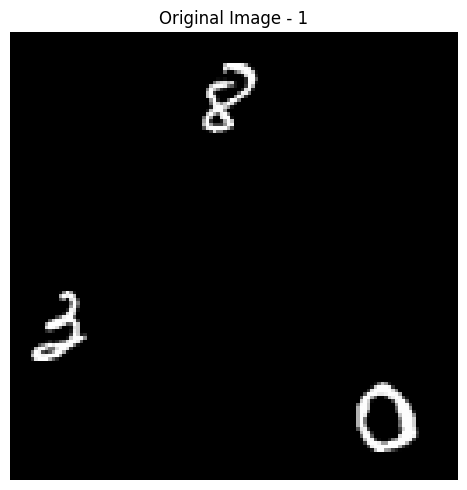

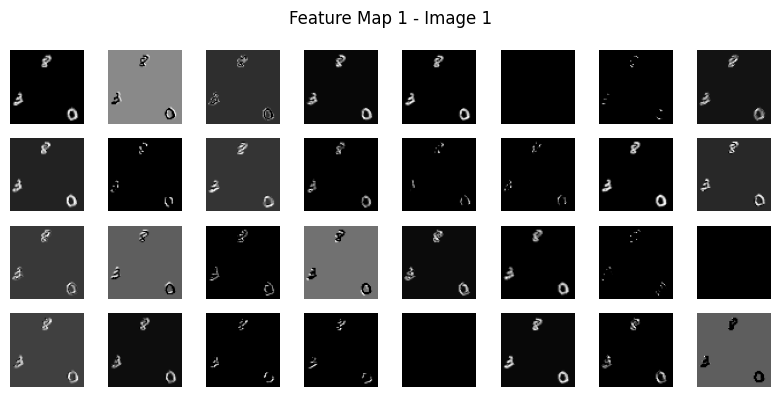

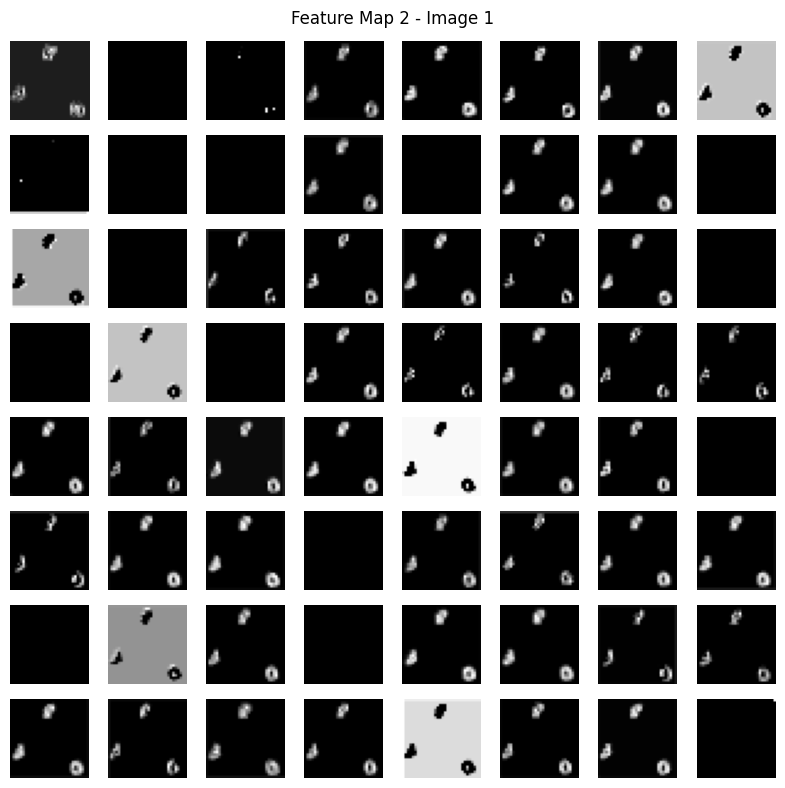

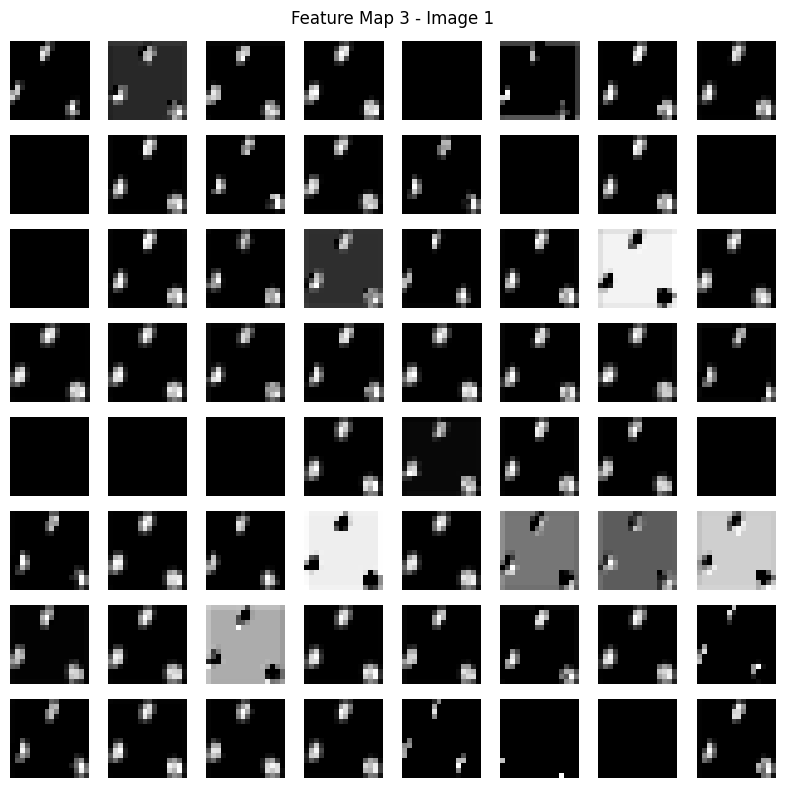

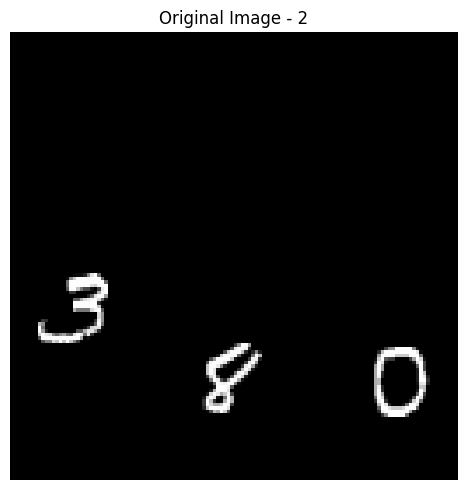

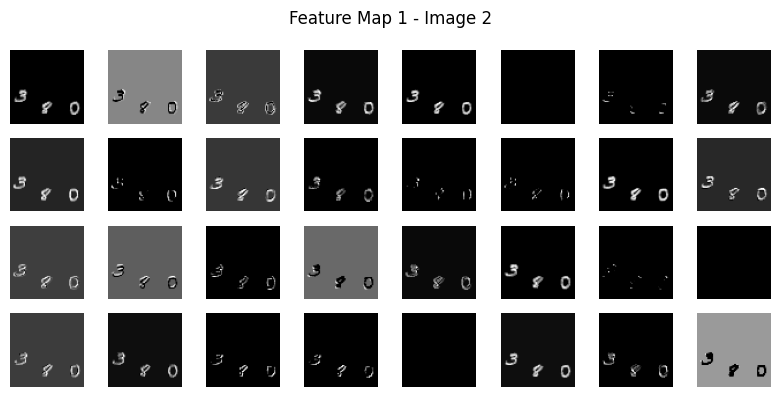

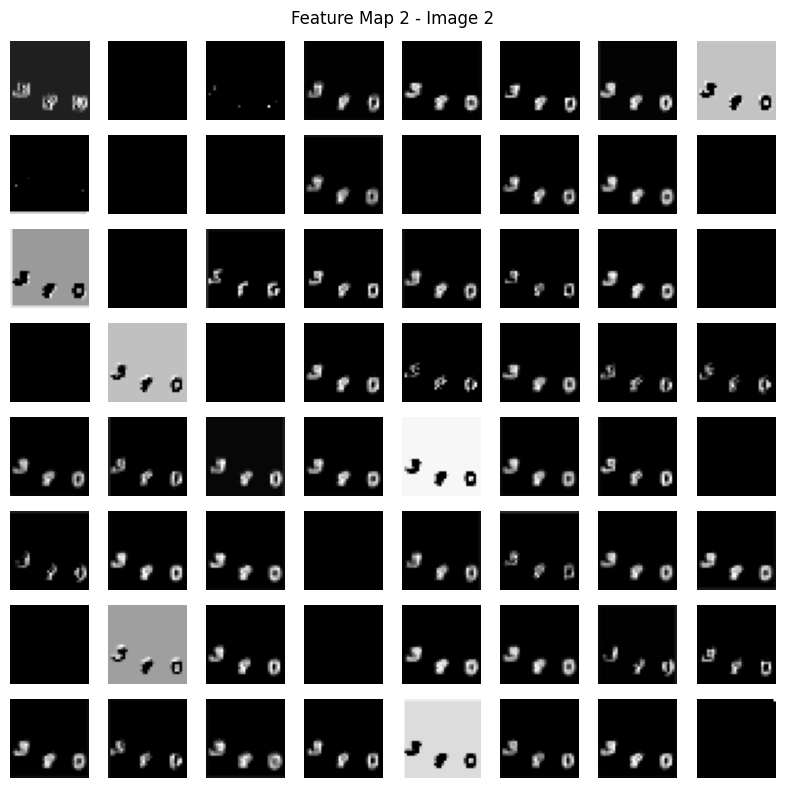

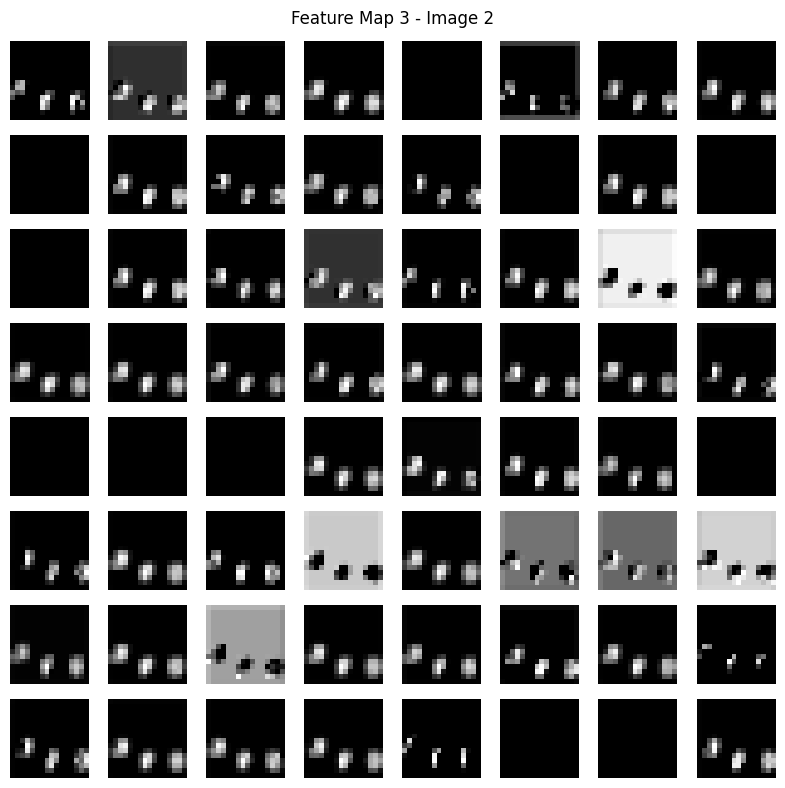

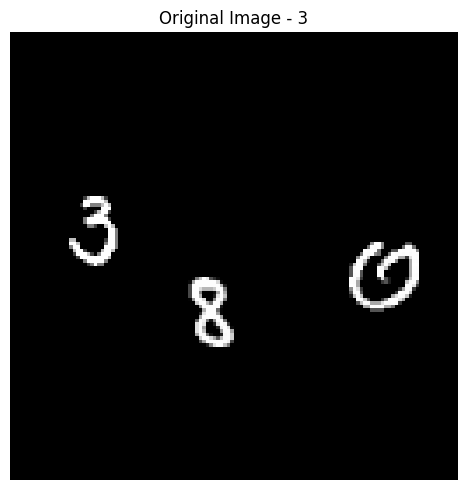

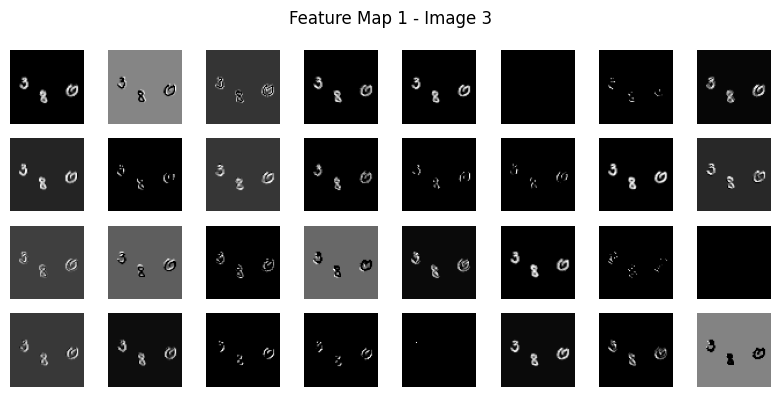

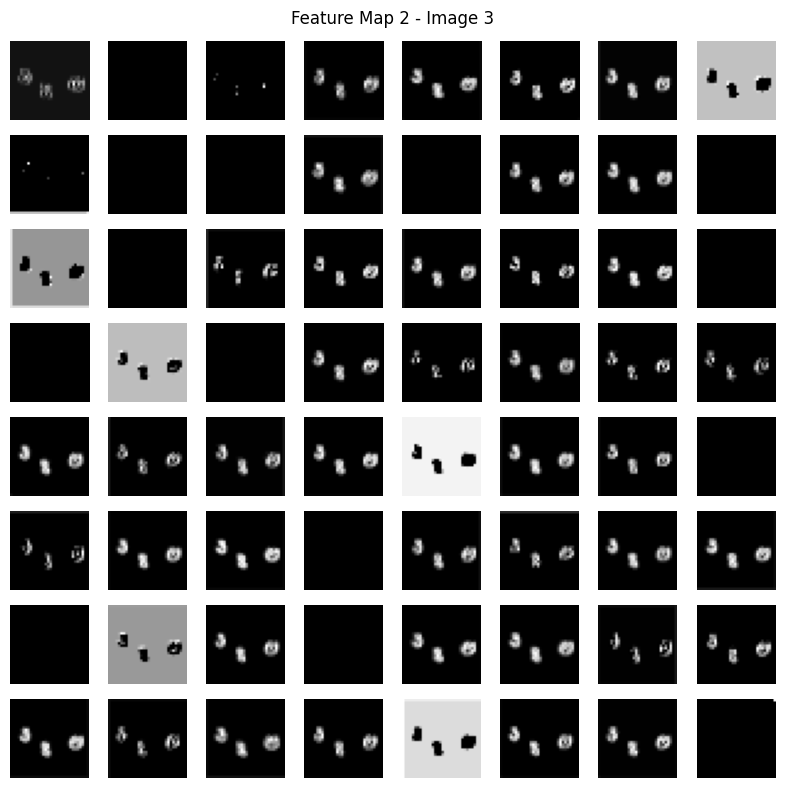

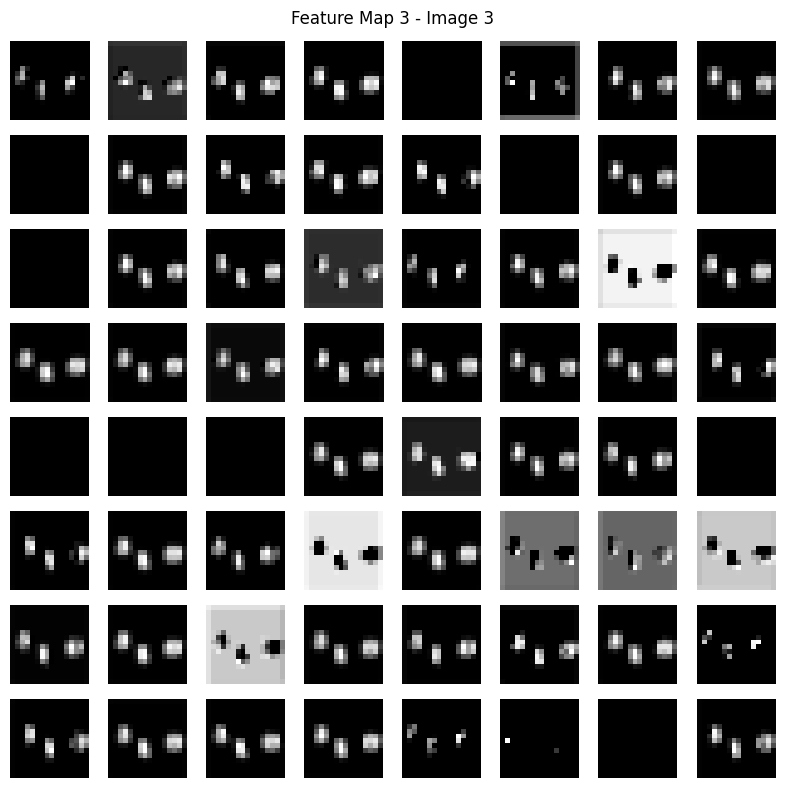

In [10]:
def visualize_feature_maps(cnn_model, test_loader, num_images=3):    
    images, _ = next(iter(test_loader))
    images = images[:num_images].to(device)
    

    _, feature_maps = cnn_model.forward(images)
    images = images.cpu().numpy()

    for i in range(num_images):
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

        ax.imshow(images[i].reshape(128, 128), cmap='gray')
        ax.set_title(f'Original Image - {i + 1}')
        ax.axis('off')
        plt.tight_layout()
        plt.savefig(f'figures/feature_map_org_img{i + 1}.png')

        fig, axs = plt.subplots(4, 8, figsize=(8, 4))
        fig.suptitle(f'Feature Map 1 - Image {i + 1}')
        for j in range(32):
            row, col = divmod(j, 8)
            axs[row, col].imshow(feature_maps[0][i][j].cpu().detach().numpy(), cmap='gray')
            axs[row, col].axis('off')
        plt.tight_layout()
        plt.savefig(f'figures/feature_map1_img{i + 1}.png')

        fig, axs = plt.subplots(8, 8, figsize=(8, 8))
        fig.suptitle(f'Feature Map 2 - Image {i + 1}')
        for j in range(64):
            row, col = divmod(j, 8)
            axs[row, col].imshow(feature_maps[1][i][j].cpu().detach().numpy(), cmap='gray')
            axs[row, col].axis('off')
        plt.tight_layout()
        plt.savefig(f'figures/feature_map2_img{i + 1}.png')

        fig, axs = plt.subplots(8, 8, figsize=(8, 8))
        fig.suptitle(f'Feature Map 3 - Image {i + 1}')
        for j in range(64):
            row, col = divmod(j, 8)
            axs[row, col].imshow(feature_maps[2][i][j].cpu().detach().numpy(), cmap='gray')
            axs[row, col].axis('off')
                
                
        plt.tight_layout()
        plt.savefig(f'figures/feature_map3_img{i + 1}.png')
        plt.show()

visualize_feature_maps(classification_model, test_loader, num_images=3)


- From the output we can say that the first layer is capturing the low level features such as edges, shapes, curves etc. 
- Second layer captures more abstract features.It is not focused on finer details but trying to  capture a whole object.
- Third layer caputre even more abstract features.Theses are more compressed version of digits.

## Multi Label Classification

### Data Loading and Preprocessing

In [11]:
def create_one_hot_map():
    labels = [-1] + [int(i) for i in range(10)]
    one_hot_map = {}
    for idx, label in enumerate(labels):
        one_hot_vector = [0] * 11  
        one_hot_vector[idx] = 1    
        one_hot_map[label] = one_hot_vector
    
    return one_hot_map


def encode_label(labels):
    one_hot_map = create_one_hot_map()
    encoded=[]
    for digit in labels:
        encoded += one_hot_map[digit]
    for _ in range(len(labels),3):
        encoded += one_hot_map[-1]

    return np.array(encoded)

def load_mnist_data_multi_label(dataset_dir):
    splits = ['train', 'val', 'test']
    data = {}

    for split in splits:
        images = []
        labels = []
        split_path = os.path.join(dataset_dir, split)
        
        for folder in os.listdir(split_path):
            folder_path = os.path.join(split_path, folder)
            
            label = [int(char) for char in folder]  
            encoded_label = encode_label(label)

            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                img = Image.open(img_path).convert('L') 
                img = np.array(img)
                images.append(img)
                labels.append(encoded_label)

        data[split] = (images, labels)
    
    return data['train'], data['val'], data['test']

class MultiMNISTDataset_multi_label(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) 
        label = torch.tensor(label, dtype=torch.float32)

        return image, label
    
train_data, val_data, test_data = load_mnist_data_multi_label('../../data/external/double_mnist')
img, labels = train_data

train_dataset = MultiMNISTDataset_multi_label(*train_data)
val_dataset = MultiMNISTDataset_multi_label(*val_data)
test_dataset = MultiMNISTDataset_multi_label(*test_data)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


### MultiLabelCNN Class

In [12]:
class MultiLabelCNN(nn.Module):
    def __init__(self, 
                 num_classes, 
                 num_labels,
                 dropout_rate=0.0, 
                 optimizer='adam', 
                 learning_rate=0.001):
        
        super(MultiLabelCNN, self).__init__()
        self.learning_rate = learning_rate
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  
        self.dropout_conv = nn.Dropout(p=dropout_rate)  

        self.fc1 = nn.Linear(64 * 16 * 16, 256)  
        self.dropout_fc = nn.Dropout(p=dropout_rate)  

        self.fc2 = nn.Linear(256, num_classes * num_labels)  
        self.loss_function = nn.CrossEntropyLoss()  
        self.train_losses = []
        self.val_losses = []

        self.init_optimizer(optimizer=optimizer)

    def init_optimizer(self, optimizer):
        if optimizer == 'adam':
            self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        elif optimizer == 'sgd':
            self.optimizer = optim.SGD(self.parameters(), lr=self.learning_rate)
        elif optimizer == 'rmsprop':
            self.optimizer = optim.RMSprop(self.parameters(), lr=self.learning_rate)
        elif optimizer == 'adagrad':
            self.optimizer = optim.Adagrad(self.parameters(), lr=self.learning_rate)
        elif optimizer == 'adadelta':
            self.optimizer = optim.Adadelta(self.parameters(), lr=self.learning_rate)

    def forward(self, x):
        if x.dim() == 5:
            x = x.squeeze(2)

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout_conv(x)

        x = x.view(-1, 64 * 16 * 16)

        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        
        x = self.fc2(x)
        return x

    def train_model(self, train_loader, val_loader, device, num_epochs=10):
        self.train_losses = []
        self.val_losses = []

        for epoch in range(num_epochs):
            self.train()
            running_loss = 0.0
            for batch_idx, (images, labels) in enumerate(train_loader):
                images, labels = images.to(device), labels.to(device)
                    
                outputs = self.forward(images)
                self.optimizer.zero_grad()
            
                t_loss = self.loss(outputs, labels)

                t_loss.backward()
                self.optimizer.step()

                running_loss += t_loss.item()
    
            train_loss = running_loss / len(train_loader)
            val_loss, _, _ = model.evaluate(val_loader, device)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

    def predict(self, image, device):
        image = image.to(device)
        outputs = self.forward(image)

        outputs = outputs.reshape(-1, 3, 11)
        _, predicted = torch.max(outputs, dim=2) 
        return predicted 

    def loss(self, y_pred, y_true):
        criterion = nn.CrossEntropyLoss()
        loss = 0
        for i in range(3):
            start = i * 11
            end = (i + 1) * 11
            target_idx = torch.argmax(y_true[:, start:end], dim=1)
            loss += criterion(y_pred[:, start:end], target_idx)
        return loss

    def evaluate(self, data_loader, device):
        self.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        hamming_accuracy_sum = 0.0

        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)
                    
                outputs = self.forward(images)
                t_loss = self.loss(outputs, labels)
                running_loss += t_loss.item()

                outputs = outputs.reshape(-1, 3, 11)
                labels = labels.reshape(-1, 3, 11)
                labels = torch.argmax(labels, dim=2)

                _, predicted = torch.max(outputs, dim=2) 
                correct += (predicted == labels).all(dim=1).sum().item()
                total += labels.size(0)
             
                hamming_accuracy_sum += torch.mean((predicted == labels).float()) 
                
        loss = running_loss / len(data_loader)
        accuracy = 100 * correct / total
        hamming_accuracy = hamming_accuracy_sum / len(data_loader)

        return loss, accuracy, hamming_accuracy

Above is the Mulit-label CNN class. This class would required additional activation function at the last layer.
- As we are predicting 3 labels(while preserving their order), here our total labels are 3 as max number of digits present in an image are 3.
- Each label can take 11 values - 0 to 9 and -1(To represent that no digit is present).After one-hot encoding for each label the final one hot vector size will be 33
- We apply Cross entropy loss over each label separately for all three labels.

### 3.3 Hyperparameter Tuning

I tried different combination of hyperparameters follow are the 6 of them with their accuracy on test dataset

| S.No.|    learning rate  | Convolution Layers | optimizer | dropout rate | epochs | Test Accuracy |
|------|-------------------|--------------------|------------|-------------|--------|---------------|
|  1   |      0.001        |      3[16,32,64]      |    adam     |  0.5      | 10   |  29.20%    |
|  2   |      0.001        |      3[16,32,64]      |    adam     |  0.0      | 10   |  37.39%   |
|  3   |      0.001        |      3[16,32,64]      |    sgd     |  0.0      | 10   |  7.93%   |
|  4   |      0.001        |      3[16,32,64]      |    rmsprop    |  0.0      | 10   |  18.89%   |
|  5   |      0.0005        |      3[16,32,64]      |    adam     |  0.3      | 10   |  47.46%   |
|  6   |      0.001        |      3[32,64]         |    adam     |  0.0      | 10   |  6.28%  |

following are the loss v/s epochs plots for these combinations:

<img src="figures/multi_lab_classification_comb1.png" alt="Loss vs Epochs" width="600"/>
<img src="figures/multi_lab_classification_comb2.png" alt="Loss vs Epochs" width="600"/>
<img src="figures/multi_lab_classification_comb3.png" alt="Loss vs Epochs" width="600"/>
<img src="figures/multi_lab_classification_comb4.png" alt="Loss vs Epochs" width="600"/>
<img src="figures/multi_lab_classification_comb5.png" alt="Loss vs Epochs" width="600"/>
<img src="figures/multi_lab_classification_comb6.png" alt="Loss vs Epochs" width="600"/>

By analysing the above plots I find combination-5 as best model configuration.I ran the model with this combination and got following results:

**Train Set**
- Exact match accuracy : 99.51%
- Hamming accuracy : 100%

**Validation Set**
- Exact match accuracy : 47.50%
- Hamming accuracy : 81%

**Test Set**
- Exact match accuracy : 41.46%
- Hamming accuracy : 79%



In [13]:
model = MultiLabelCNN(
                    num_labels=3, 
                    num_classes=11,
                    dropout_rate=0.3,
                    learning_rate=0.0005,
                    optimizer='adam').to(device)

model.train_model(train_loader, val_loader, device, num_epochs=10)

print(f"Evaluation:")
loss, accuracy, hamming_accuracy = model.evaluate(train_loader, device)
print("Train Set - ")
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%, Hamming Accuracy: {hamming_accuracy:.2f}")
loss, accuracy, hamming_accuracy = model.evaluate(val_loader, device)
print("Validation Set - ")
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%, Hamming Accuracy: {hamming_accuracy:.2f}")
loss, accuracy, hamming_accuracy = model.evaluate(test_loader, device)
print("Test Set - ")
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%, Hamming Accuracy: {hamming_accuracy:.2f}")


Epoch [1/10], Train Loss: 4.9663, Val Loss: 4.6571
Epoch [2/10], Train Loss: 3.2550, Val Loss: 3.7548
Epoch [3/10], Train Loss: 2.0759, Val Loss: 3.0493
Epoch [4/10], Train Loss: 1.3761, Val Loss: 2.7595
Epoch [5/10], Train Loss: 0.9784, Val Loss: 2.6696
Epoch [6/10], Train Loss: 0.7492, Val Loss: 2.6803
Epoch [7/10], Train Loss: 0.6007, Val Loss: 2.7770
Epoch [8/10], Train Loss: 0.5177, Val Loss: 2.6364
Epoch [9/10], Train Loss: 0.4335, Val Loss: 2.6659
Epoch [10/10], Train Loss: 0.3998, Val Loss: 2.7072
Evaluation:
Train Set - 
Loss: 0.0349, Accuracy: 99.67%, Hamming Accuracy: 1.00
Validation Set - 
Loss: 2.7072, Accuracy: 46.90%, Hamming Accuracy: 0.80
Test Set - 
Loss: 3.2585, Accuracy: 41.26%, Hamming Accuracy: 0.79
